# Test With Indipendant Embedding Models

# Imports

In [1]:
import os
import pickle
import transformers
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# Environment Setup

In [2]:
# There are important!
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

## Model Initialization

### infly/inf-retriever-v1

In [3]:
# model_id = "/media/ANONYMOUS/4TB_2/LLM_models/infly/inf-retriever-v1"

# tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
# model = AutoModel.from_pretrained(model_id, trust_remote_code=True, torch_dtype=torch.bfloat16, device_map="cuda")
# max_length = 512

### infly/inf-retriever-v1-1.5b

In [4]:
model_id = "/media/ANONYMOUS/Files/models/infly/inf-retriever-v1-1.5b"

model = SentenceTransformer(model_id, trust_remote_code=True)
model.max_seq_length = 8192

# Get Dataset

In [5]:
project_base_path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
project_base_path

'/media/ANONYMOUS/Files/projects/FALCON'

In [6]:
gpt4o_generated_cti_path = os.path.join(project_base_path, "data/generation/yara/yara-rules_v1.pkl")
gpt4o_generated_cti_path

'/media/ANONYMOUS/Files/projects/FALCON/data/generation/yara/yara-rules_v1.pkl'

In [7]:
def load_from_pickle(file_path):
    """
    Loads data from a pickle file.

    :param file_path: Path to the pickle file
    :return: Loaded data
    """
    try:
        with open(file_path, 'rb') as file:
            return pickle.load(file)
    except Exception as e:
        print(f"Error loading data from pickle: {e}")
        return None

In [8]:
# Load the data back from the pickle file
file_path = gpt4o_generated_cti_path

gpt_yara_cti_dict = load_from_pickle(file_path)
size = len(gpt_yara_cti_dict.keys()) 
print(size)

4588


In [9]:
def get_first_n_elements(dictionary: dict, n: int) -> dict:
    """
    Get the first n elements of a dictionary.

    :param dictionary: The input dictionary
    :param n: The number of elements to retrieve
    :return: A dictionary with the first n elements
    """
    return dict(list(dictionary.items())[:n])

In [10]:
yara_cti_sample_dict = get_first_n_elements(gpt_yara_cti_dict, 10)

In [11]:
yara_cti_sample_dict

{'rule MSIETabularActivex\n{\n        meta:\n                ref = "CVE-2010-0805"\n                impact = 7\n                hide = true\n                author = "@d3t0n4t0r"\n        strings:\n                $cve20100805_1 = "333C7BC4-460F-11D0-BC04-0080C7055A83" nocase fullword\n                $cve20100805_2 = "DataURL" nocase fullword\n                $cve20100805_3 = "true"\n        condition:\n                ($cve20100805_1 and $cve20100805_3) or (all of them)\n}': 'Rule Name\n  MSIETabularActivex\n\nDescription\n  This YARA rule detects a specific vulnerability (CVE-2010-0805) associated with an ActiveX control. The rule targets potentially malicious strings that could be used in exploit attempts related to this vulnerability.\n\nReference\n  CVE-2010-0805\n\nIndicators / String Matches\n  This rule matches the following strings:\n\n  String ID\tPattern\tNotes\n  $cve20100805_1\t"333C7BC4-460F-11D0-BC04-0080C7055A83"\tActiveX control CLSID\n  $cve20100805_2\t"DataURL"\tPos

In [12]:
yaras, ctis = zip(*yara_cti_sample_dict.items())
yaras = list(yaras)
ctis = list(ctis)

In [13]:
len(yaras), len(ctis)

(10, 10)

In [14]:
yaras[0]

'rule MSIETabularActivex\n{\n        meta:\n                ref = "CVE-2010-0805"\n                impact = 7\n                hide = true\n                author = "@d3t0n4t0r"\n        strings:\n                $cve20100805_1 = "333C7BC4-460F-11D0-BC04-0080C7055A83" nocase fullword\n                $cve20100805_2 = "DataURL" nocase fullword\n                $cve20100805_3 = "true"\n        condition:\n                ($cve20100805_1 and $cve20100805_3) or (all of them)\n}'

In [15]:
ctis[0]

'Rule Name\n  MSIETabularActivex\n\nDescription\n  This YARA rule detects a specific vulnerability (CVE-2010-0805) associated with an ActiveX control. The rule targets potentially malicious strings that could be used in exploit attempts related to this vulnerability.\n\nReference\n  CVE-2010-0805\n\nIndicators / String Matches\n  This rule matches the following strings:\n\n  String ID\tPattern\tNotes\n  $cve20100805_1\t"333C7BC4-460F-11D0-BC04-0080C7055A83"\tActiveX control CLSID\n  $cve20100805_2\t"DataURL"\tPossible exploit-related term\n  $cve20100805_3\t"true"\tPotential Boolean indicator used in exploitation\n\n  All string patterns use nocase and fullword modifiers, allowing detection regardless of case and requiring exact word matches.\n\nCondition Logic\n  The rule triggers if:\n\n  The ActiveX control CLSID ($cve20100805_1) and the Boolean indicator ($cve20100805_3) are both present.\n\n  Alternatively, if all strings ($cve20100805_1, $cve20100805_2, and $cve20100805_3) are fo

# Attention Functions

In [16]:
# def last_token_pool(last_hidden_states: torch.Tensor,
#                  attention_mask: torch.Tensor) -> torch.Tensor:
#     left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
#     if left_padding:
#         return last_hidden_states[:, -1]
#     else:
#         sequence_lengths = attention_mask.sum(dim=1) - 1
#         batch_size = last_hidden_states.shape[0]
#         return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]

In [17]:
# # Tokenize the yaras
# batch_dict = tokenizer(yaras, max_length=max_length, padding=True, truncation=True, return_tensors='pt').to('cuda')
# outputs = model(**batch_dict)
# rule_embeddings = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

In [18]:
# # Tokenize the yaras
# batch_dict = tokenizer(ctis, max_length=max_length, padding=True, truncation=True, return_tensors='pt')
# outputs = model(**batch_dict)
# desc_embeddings = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

In [19]:
# Step 1: Encode descriptions and rules
desc_embeddings = model.encode(ctis, convert_to_tensor=True)  # [num_desc x 1536]
rule_embeddings = model.encode(yaras, convert_to_tensor=True)        # [num_rules x 1536]

In [20]:
rule_embeddings.shape

torch.Size([10, 1536])

In [21]:
desc_embeddings.shape

torch.Size([10, 1536])

In [22]:
def compute_attention_softmax_matrix(tensor_a, tensor_b):
    """
    Computes a [B, B] attention matrix using cosine similarity between
    [seq_len, hidden_dim] slices of two tensors, then applies row-wise softmax.

    Args:
        tensor_a (Tensor): Tensor of shape [B, seq_len, hidden_dim]
        tensor_b (Tensor): Tensor of shape [B, seq_len, hidden_dim]

    Returns:
        Tensor: Softmax-normalized attention matrix of shape [B, B]
    """
    
    assert tensor_a.size(0) == tensor_b.size(0), "Batch sizes must match"
    assert tensor_a.size(-1) == tensor_b.size(-1), "Hidden dimensions must match"
    
    # Step 2: Compute dot product matrix [num_desc x num_rules]
    dot_product_matrix = torch.matmul(tensor_a, tensor_b.T)


    # Apply softmax row-wise to turn into attention weights
    attention_weights = F.softmax(dot_product_matrix, dim=1)
    return attention_weights




In [23]:
def plot_attention_map(attention_tensor, title="Attention Map", figsize=(7.5, 4.5), annot=False):
    """
    Plots a heatmap of a [B, B] attention matrix using seaborn.

    Args:
        attention_tensor (Tensor): Attention tensor of shape [B, B]
        title (str): Title of the plot
        figsize (tuple): Size of the figure
        annot (bool): Whether to annotate the heatmap values
    """
    
    if isinstance(attention_tensor, torch.Tensor):
        attention_tensor = attention_tensor.to(dtype=torch.float32).detach().cpu().numpy()
    
    
    plt.figure(figsize=figsize)
    sns.heatmap(attention_tensor, annot=True, cmap="YlGnBu", 
                xticklabels=[f"Rule {i+1}" for i in range(len(yaras))], 
                yticklabels=[f"Desc {i+1}" for i in range(len(ctis))])
    plt.title("Softmax Attention Weights: Descriptions → Rules")
    plt.xlabel("Yara Rules")
    plt.ylabel("Descriptions")
    plt.tight_layout()
    plt.show()

# Generate Attention Map

In [24]:
attn_matrix = compute_attention_softmax_matrix(rule_embeddings, desc_embeddings)

In [25]:
print(attn_matrix.shape)  # torch.Size([10, 10])

torch.Size([10, 10])


In [26]:
attn_matrix

tensor([[0.1097, 0.0990, 0.0964, 0.0997, 0.0969, 0.0995, 0.0999, 0.0996, 0.0997,
         0.0997],
        [0.0995, 0.1126, 0.0992, 0.0993, 0.0964, 0.0988, 0.0982, 0.0978, 0.0997,
         0.0984],
        [0.0988, 0.0986, 0.1107, 0.0975, 0.0985, 0.1014, 0.0982, 0.0978, 0.0991,
         0.0994],
        [0.0987, 0.0974, 0.0957, 0.1105, 0.0977, 0.0991, 0.1002, 0.0996, 0.1007,
         0.1004],
        [0.0994, 0.0971, 0.0985, 0.1000, 0.1095, 0.0996, 0.0998, 0.0977, 0.0995,
         0.0987],
        [0.0999, 0.0971, 0.0977, 0.0994, 0.0981, 0.1087, 0.0996, 0.0985, 0.1004,
         0.1006],
        [0.0965, 0.0931, 0.0939, 0.0977, 0.0951, 0.0962, 0.1096, 0.1053, 0.1064,
         0.1062],
        [0.0966, 0.0938, 0.0936, 0.0977, 0.0939, 0.0958, 0.1068, 0.1092, 0.1062,
         0.1064],
        [0.0965, 0.0941, 0.0939, 0.0975, 0.0954, 0.0969, 0.1062, 0.1046, 0.1086,
         0.1062],
        [0.0961, 0.0934, 0.0942, 0.0976, 0.0948, 0.0967, 0.1062, 0.1053, 0.1063,
         0.1095]], device='c

# Plot Attention

### infly/inf-retriever-v1-1.5b

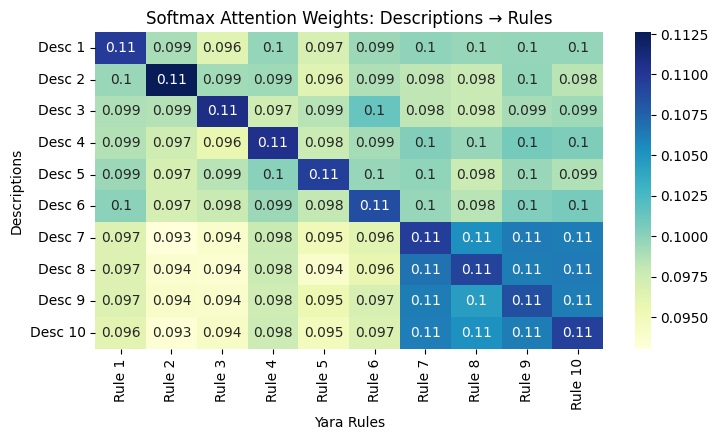

In [27]:
plot_attention_map(attn_matrix, title="Cosine Similarity Attention", annot=True)